## Text Classification using fine-tuned GPT-2 model

## Install and import packages

In [ ]:
# !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install sklearn
# !pip3 install tqdm
# !pip3 install transformers

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Setup Google Drive
here i also create folder in my drive with name ColabNotebooks

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/ColabNotebooks/

/content/drive/My Drive/ColabNotebooks


##Read data from drive into dataframe

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('./train_df.csv')
# df = pd.read_csv('./bbc-text.csv')

In [ ]:
df.head()

,label,text
0,0,We were greeted in an inquisitive but friendly...
1,0,"In the flat below , a teenage couple quarrelle..."
2,0,The phrase '' Protocols-style '' carries a cri...
3,0,By its light Rachaela saw Adamus lie Ruth on h...
4,0,"Widowed at twenty-two , left with a small baby ."


## Change Column type from int to Obj

In [ ]:
df = df.astype(str)
print(df.dtypes)

label    object
text     object
dtype: object


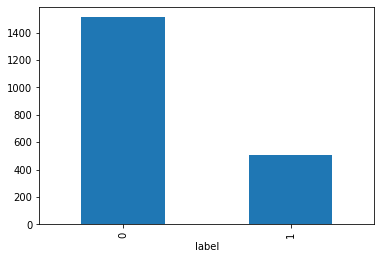

In [ ]:
df.groupby("label").size().plot.bar()

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [ ]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [ ]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


## Dataset class

Here we will build a custom Dataset class to read in our news data, tokenize them, and store them into containers for batch training using PyTorch.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "0": 0,
    "1": 1
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1612 202 202


##Model building Code

We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 2 numbers which corresponds to our five news categories!

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following this guide. Since this is a multi-class classification problem, I picked cross-entropy-loss as our loss function ("criterion"), and Adam as the optimization algorithm and using training epoch as 1 you can set it to 3 5  etc as per your choice. 

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 806/806 [51:58<00:00,  3.87s/it]


Epochs: 1 | Train Loss:  0.243             | Train Accuracy:  0.782             | Val Loss:  0.349             | Val Accuracy:  0.767


*Looks* like the model is already well trained after 1 epoch! This is probably due to the fact that as a pre-trained model with gigantic number of parameters, GPT-2 is already capable of differentiating different text paragraphs without too much tuning.

## Evaluation
After model training, it's recommended to use the test data to evaluate the model performance on unseen data. I build the evaluate function according this PyTorch guide.

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.748


here we got 75 % acc with just 1 epochs you can try 3 epocs and your model will return 95 % accuracy. i use i epoch because i have less cpu and ram

## Another good gauge of model performance is the confusion matrix.

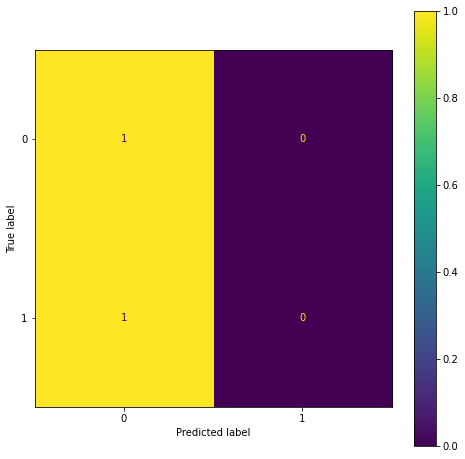

In [ ]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model

After training, we need to save the model locally. PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [ ]:
# save trained model
torch.save(model.state_dict(), "./gpt_model/gpt2-text-classifier-model.pt")

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./gpt_model/gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dr

## Model Inference

In [ ]:
example_text = """
A graduate scientist is required in the Measurement and Instrumentation Section to work on a range of projects concerning analysis of beer and its raw materials .
"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
print(model_input)

a graduate scientist is required in the measurement and instrumentation section to work on a range of projects concerning analysis of beer and its raw materials .
{'input_ids': tensor([[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
            64, 10428, 11444,   3

After text tokenization, we need to extract two inputs for the model, input_id and mask.

In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [ ]:
print(mask.shape)
print(input_id.shape)

torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
print(output)


tensor([[ 1.3731, -2.6936]], grad_fn=<AddmmBackward0>)


The output here is the model output for each label. We can normalize them as probabilities using Softmax algorithm.

In [ ]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [ ]:
print(prob)


tensor([0.9832, 0.0168], grad_fn=<SelectBackward0>)


Let's see if our predictor can correctly classify this label 0/1

In [ ]:
labels_map = {
    0: "0",
    1: "1"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

0


In [ ]:
def compute_number_batches(input_length, batch_size):
  if input_length % batch_size == 0:
    return input_length // batch_size
  else:
    return input_length // batch_size + 1

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
#model = GPT2Model.from_pretrained("gpt2")
model1 = model_new
text = df['text'].tolist()
print(len(text))
batch_size = 36

featuresds = np.zeros((len(text), 768))
# print("featuresds",featuresds)
print("compute_number_batches(len(text), batch_size)",compute_number_batches(len(text), batch_size))
for batch in range(compute_number_batches(len(text), batch_size)):
  print('Printing batch n. {} of {}'.format(batch + 1, compute_number_batches(len(text), batch_size)))
  # fixed_text1=''.join(text[batch*batch_size : (batch+1)*batch_size])
  # fixed_text1=fixed_text1.lower().split()
  inputs = tokenizer(text[batch*batch_size : (batch+1)*batch_size], padding='max_length', max_length=30, truncation=True, return_tensors="pt")
  print(inputs)

  mask = inputs['attention_mask'].cpu()
  input_id = inputs["input_ids"].squeeze(1).cpu()
  # outputs = model1(input_id, mask)
  print(mask.shape)
  print(input_id.shape)
  break
  # last_hidden_states = outputs.last_hidden_state
  # sentemb = last_hidden_states.detach().numpy()[:,last_hidden_states.shape[1]-1]
  # featuresds[batch * batch_size: (batch + 1)* batch_size] = sentemb

2016
compute_number_batches(len(text), batch_size) 56
Printing batch n. 1 of 56
{'input_ids': tensor([[50256, 50256, 50256,  ...,  5509,   764,   220],
        [50256, 50256, 50256,  ...,   262,  2240,   764],
        [50256,   464,  9546,  ..., 10086,  4583,   764],
        ...,
        [50256, 50256, 50256,  ..., 42922,   764,   220],
        [50256, 50256, 50256,  ...,  2746, 32808,   764],
        [50256, 50256, 50256,  ...,    66, 39975,   764]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}
torch.Size([36, 30])
torch.Size([36, 30])


In [ ]:
2016%36

0